In [140]:
from xflowrl.util.util import plot_to_image, plot_xfer_heatmap
from collections import OrderedDict
import seaborn as sns
import json
import pandas as pd
import os
import numpy as np

# Utils

In [141]:
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_figure(name, path, sb_axes):
    fig = sb_axes.get_figure()
    fig.savefig(f'{path}/{name}.png', dpi=600)
    
def get_files_from_dir(folder):
    paths = []
    with os.scandir(folder) as it:
        for entry in it:
            if entry.name.endswith(".json") and entry.is_file():
                paths.append((entry.path, entry.name))
    return paths

def set_seaborn_style():
    sns.set_style('whitegrid', {'axes.grid':False, 'axes.edgecolor':'black', 'axes.linewidth':0, 'xtick.bottom':True, 'ytick.left':True})

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.1
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontweight='bold', fontsize=10) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

set_seaborn_style()

In [ ]:
xfers_applied = {'100': 10, '90': 30, '3': 5, '60': 15}
print({'xfer': [int(k) for k in xfers_applied.keys()], 'count': [v for _, v in xfers_applied.items()] })
xfers_applied_1 = {'xfer': [100, 67, 9, 151], 'count': [10, 15, 5, 7]}

   xfer  count
0   100     10
1    67     15
2     9      5
3   151      7


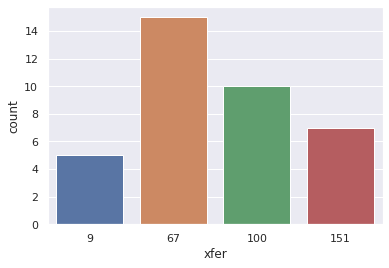

In [3]:
fig = plot_xfer_heatmap(xfers_applied)

# Pair plot of detailed costs

In [33]:
def plot_pair_grid(graph, timestamp):
    data = dict(runtime=[], flops=[], mem_acc=[], num_kernels=[], graph=[])
    
    if not isinstance(graph, list):
        graph = [graph]
    if not isinstance(timestamp, list):
        timestamp = [timestamp]
    
    
    for i, _ in enumerate(graph):
        path = f'../logs/xflowrl/{graph[i]}/{timestamp[i]}/runtime_info.json'
        detailed_costs = load_json(path)

        for e in detailed_costs:
            for k, v in e.items():
                data[k].append(v)
        data['graph'].extend([graph[i]] * len(detailed_costs))

    df = pd.DataFrame.from_dict(data)
    print(df.head())
    g = sns.PairGrid(df, hue='graph')
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()

    runtime     flops     mem_acc  num_kernels        graph
0  1.385149  1.315675  124.513184        21984  squeezenet1
1  1.363356  1.398332  127.303223        21986  squeezenet1
2  1.383611  1.407999  122.791748        21985  squeezenet1
3  1.414033  1.315675  124.843262        21985  squeezenet1
4  1.353070  1.404698  122.189453        21984  squeezenet1


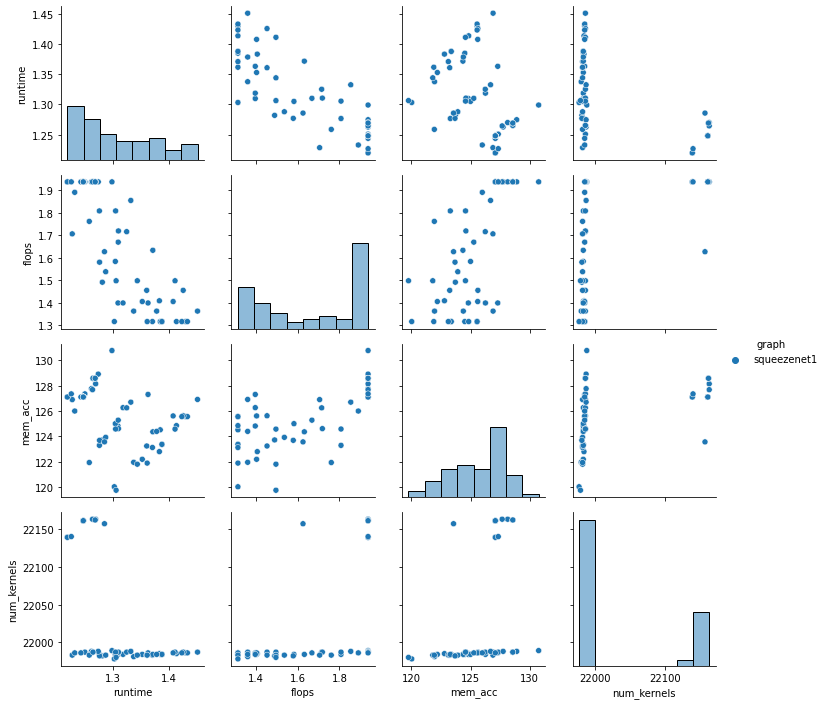

In [34]:
#graphs = ['BERT', 'squeezenet1']
#timestamps = ['20210309-161428', '20210311-184605']
#plot_pair_grid(graphs, timestamps)

plot_pair_grid('squeezenet1', '20210311-184605')

# MB controller training reward line graph

In [138]:
def plot_training_reward(graphs):
    data = dict(value=[], timestep=[], graph=[])
    graph_map = {'squeezenet1': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'InceptionV3': 'InceptionV3', 'BERT': 'BERT'}
    graph_names = []
    all_df = pd.DataFrame.from_dict(data)
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], graph=[])
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        min_v, max_v = 1e6, -1e6
        temp_vals = []
        for e in json_data:
            data['timestep'].append(e[1])
            temp_vals.append(e[2])
            min_v = min(min_v, e[2])
            max_v = max(max_v, e[2])
        data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])
        data['graph'].extend([graph] * len(json_data))
        df = pd.DataFrame.from_dict(data)
        df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        all_df = pd.concat([all_df, df])
        

    # df = pd.DataFrame.from_dict(data)
    
    # print(df.head())
    ax = sns.lineplot(x='timestep', y='value', data=all_df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Normalised Reward', title='Predicted agent reward by world model for given graph')
    ax.legend(labels=graph_names, frameon=False)
    save_figure('mb_ctrl_training_reward', '../plots', ax)

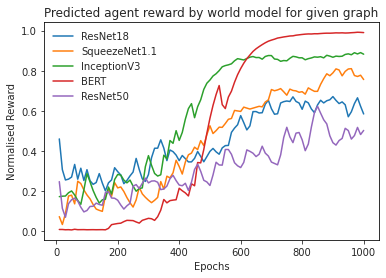

In [139]:
paths = get_files_from_dir('../chart_data/worldmodel_agent_reward')
plot_training_reward(paths)

# World model training loss line graph

In [101]:
def plot_training_loss_world_model(paths):
    data = dict(value=[], timestep=[], graph=[])
    
    for path, file_name in paths:
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        for e in json_data:
            data['timestep'].append(e[1])
            data['value'].append(e[2])
        data['graph'].extend([graph] * len(json_data))

    df = pd.DataFrame.from_dict(data)
    df['value'] = df.ewm(alpha=(1 - 0.4)).mean()
    print(df.head())
    sns.set_style('whitegrid', {'axes.grid':False, 'axes.edgecolor':'black', 'axes.linewidth':0, 'xtick.bottom':True, 'ytick.left':True})
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(xlabel='Epochs', ylabel='Log-likelihood Loss', title='World Model Training Loss')
    ax.legend(labels=['BERT', 'ResNet50', 'SqueezeNet1.1', 'InceptionV3', 'ResNet18'], frameon=False)
    save_figure('mb_training_loss', '../plots', ax)

      value  timestep graph
0  0.874853        10  BERT
1  0.855583        20  BERT
2  0.492447        30  BERT
3  0.363423        40  BERT
4  0.245316        50  BERT


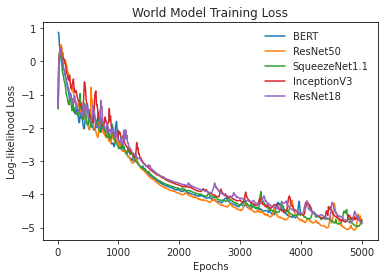

In [102]:
paths = get_files_from_dir('../chart_data/worldmodel_loss')
plot_training_loss_world_model(paths)

# Baseline methods runtimes

In [87]:
def plot_runtimes_bar_chart(paths):
    backend_map = {'tf': 'TensorFlow', 'trt': 'TensorRT', 'taso': 'TASO', 'xflowrl': 'XflowRL'}
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    data = dict(runtime=[], backend=[], graph=[])
    graph_order = []
    for path, _ in paths:
        json_data = load_json(path)
        print(json_data.keys())
        for k in json_data.keys():
            for backend, obj in json_data[k]['runtime'].items():
                if backend != 'xflowrl':
                    data['runtime'].append(obj['mean'])
                    data['backend'].append(backend_map[backend])
                    data['graph'].append(k)
            graph_order.append(k)
            
    print(data)
    df = pd.DataFrame.from_dict(data)
    print(df.head())
    
    g = sns.FacetGrid(df, col='graph', sharey=False)
    g.map(sns.barplot, 'backend', 'runtime')
    g.set_axis_labels('', 'Inference Time (ms)')
    
    for i, graph in enumerate(graph_order):
        g.axes[0,i].set_xlabel(graph_map[graph], fontsize=16)
    
    axes = g.axes.flatten()
    for i in range(0, 5):
        axes[i].set_title('')
    #ax = sns.barplot(x='backend', y='runtime', data=df)
    #ax.set(xlabel='Runtime backend', ylabel='Inference Time (ms)', title='Inference time using baseline methods')
    #ax.legend(labels=['BERT', 'ResNet50', 'SqueezeNet1.1', 'InceptionV3', 'ResNet18'], frameon=False)
    g.savefig('../plots/baseline_runtimes.png')

In [4]:
paths = get_files_from_dir('../results/test_runtime')
#plot_runtimes_bar_chart(paths)

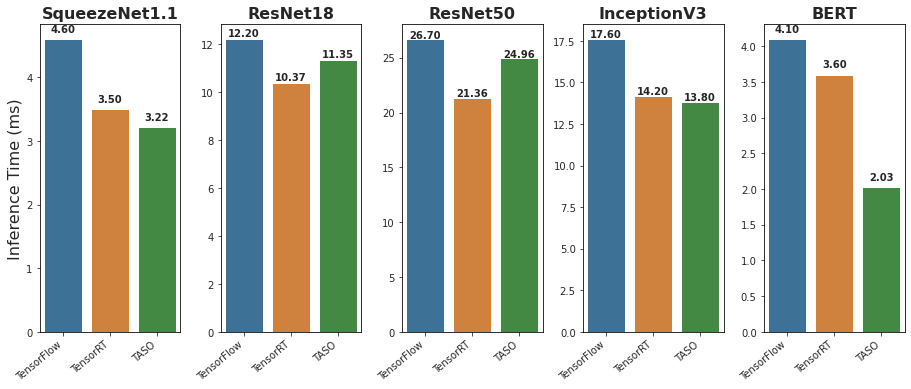

In [90]:
g = sns.catplot(x='backend', y='runtime', col='graph',
                data=df, kind="bar", saturation=0.6, ci=None, sharey=False, aspect=0.5)
g.set_axis_labels('', 'Inference Time (ms)', fontsize=16)
g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
axes = g.axes.flatten()
graphs = ['SqueezeNet1.1', 'ResNet18', 'ResNet50', 'InceptionV3', 'BERT']
for i, label in enumerate(graphs):
    axes[i].set_title(label, fontsize=16, fontweight='bold')
#for i, label in enumerate(graphs):
#        g.axes[0,i].set_xlabel(label, fontsize=16)
for ax in axes:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')

show_values_on_bars(axes)
g.savefig('../plots/baseline_runtimes.png')

# World model reward prediction

In [168]:
def plot_reward_prediction(graphs):
    data = dict(value=[], timestep=[], graph=[])
    graph_map = {'squeezenet1': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'InceptionV3': 'InceptionV3', 'BERT': 'BERT'}
    graph_names = []
    all_df = pd.DataFrame.from_dict(data)
    for path, file_name in graphs:
        data = dict(value=[], timestep=[], graph=[])
        json_data = load_json(path)
        graph = file_name.split('_')[0]
        graph_names.append(graph_map[graph])
        
        arr1 = json_data['reward'][-1]
        arr2 = json_data['real_reward'][-1]
        for i in enumerate(arr1):
            data['value'].append(float(i[1]))
            data['timestep'].append(i[0])
        data['graph'].extend(['pred'] * len(arr1))
        
        for i in enumerate(arr2):
            data['value'].append(float(i[1]))
            data['timestep'].append(i[0])
        data['graph'].extend(['real'] * len(arr1))
        break
        
        #min_v, max_v = 1e6, -1e6
        #temp_vals = []
        #for i, e in enumerate(json_data):
        #    data['timestep'].append(i)
        #    temp_vals.append(e[2])
        #    min_v = min(min_v, e[2])
        #    max_v = max(max_v, e[2])
        #data['value'].extend([(v - min_v) / (max_v - min_v) for v in temp_vals])
        #data['graph'].extend([graph] * len(json_data))
        #df = pd.DataFrame.from_dict(data)
        #df['value'] = df.ewm(alpha=(1 - 0.85)).mean()
        #all_df = pd.concat([all_df, df])
        

    df = pd.DataFrame.from_dict(data)
    
    # print(df.head())
    #g = sns.FacetGrid(df, row='sex', col='smoker')
    #g.map(sns.lineplot, 'timestep', 'tip')
    ax = sns.lineplot(x='timestep', y='value', data=df, hue='graph')
    ax.set(ylim=(0, 5))
    #ax.set(xlabel='Epochs', ylabel='Normalised Reward', title='Predicted agent reward by world model for given graph')
    #ax.legend(labels=graph_names, frameon=False)
    #save_figure('mb_ctrl_training_reward', '../plots', ax)

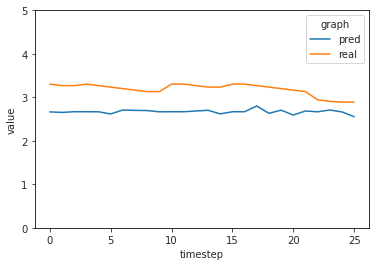

In [169]:
paths = get_files_from_dir('../results/test_reward')
plot_reward_prediction(paths)

# Model-based runtimes

In [188]:
def plot_runtimes_bar_chart_all(paths):
    backend_map = {'tf': 'TensorFlow', 'trt': 'TensorRT', 'taso': 'TASO', 'xflowrl_mf': 'Model-free', 'xflowrl_mb': 'Model-based'}
    graph_map = {'squeezenet': 'SqueezeNet1.1', 'resnet18': 'ResNet18', 'resnet50': 'ResNet50', 'inceptionv3': 'InceptionV3', 'bert': 'BERT'}
    data = dict(runtime=[], backend=[], graph=[])
    graph_order = []
    for path, _ in paths:
        json_data = load_json(path)
        print(json_data.keys())
        for k in json_data.keys():
            for backend, obj in json_data[k]['runtime'].items():
                data['runtime'].append(obj['mean'])
                data['backend'].append(backend_map[backend])
                data['graph'].append(k)
            graph_order.append(k)
            
    df = pd.DataFrame.from_dict(data)
    
    g = sns.catplot(x='backend', y='runtime', col='graph',
                data=df, kind="bar", saturation=0.6, ci=None, sharey=False, aspect=0.5)
    g.set_axis_labels('', 'Inference Time (ms)', fontsize=16)
    axes = g.axes.flatten()
    graphs = ['SqueezeNet1.1', 'ResNet18', 'ResNet50', 'InceptionV3', 'BERT']
    for i, label in enumerate(graphs):
        axes[i].set_title(label, fontsize=16, fontweight='bold')
    #for i, label in enumerate(graphs):
    #        g.axes[0,i].set_xlabel(label, fontsize=16)
    for ax in axes:
        g.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_color('black')

    show_values_on_bars(axes)
    g.savefig('../plots/all_runtimes.png')

dict_keys(['squeezenet', 'resnet18', 'resnet50', 'inceptionv3', 'bert'])


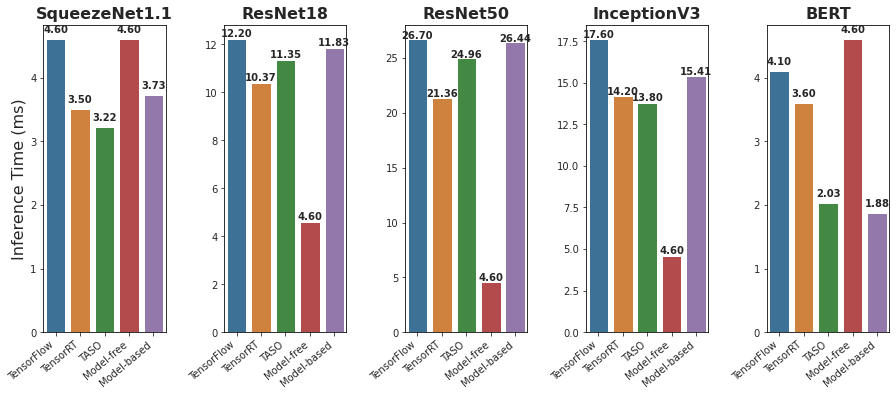

In [189]:
paths = get_files_from_dir('../results/test_runtime')
plot_runtimes_bar_chart_all(paths)